In [1]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
from openpyxl import drawing
from openpyxl.utils.dataframe import dataframe_to_rows
import os
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
def stock_adjclose(Tickers, start_y, start_m, start_d, end_y, end_m, end_d):
    start = datetime.datetime(start_y, start_m, start_d).strftime("%Y-%m-%d")
    end = datetime.datetime(end_y, end_m, end_d).strftime("%Y-%m-%d")
    #Tickers = ' '.join(Tickers)
    data = yf.download(Tickers, start, end)
    data = data[['Adj Close']]
    data = data.round(decimals=2) 
    return data

def Export_to_Excel(df, sheet, start_row, start_col, index = False, header = True):
    for index_row, row in enumerate(dataframe_to_rows(df, index=index, header = header), start_row):
        if index_row == start_row:
            continue

        for index_col, info in enumerate(row, start_col):
            sheet.cell(index_row, index_col).value = info

In [4]:
def calender_start1():
    def print_sel():
        start_date_button1["text"] = cal.selection_get()
        start_date1 = cal.selection_get()
        print(start_date1)
        top.destroy()

    top = tk.Toplevel(window)

    cal = Calendar(top,
                   font="Arial 14", selectmode='day',
                   cursor="hand1", year=2010, month=1, day=1)
    cal.pack(fill="both", expand=True)
    tk.Button(top, text="ok", command=print_sel).pack()

def calender_end1():
    def print_sel():
        end_date_button1["text"] = cal.selection_get()
        end_date1 = cal.selection_get()
        print(end_date1)
        top.destroy()

    top = tk.Toplevel(window)

    cal = Calendar(top,
                   font="Arial 14", selectmode='day',
                   cursor="hand1", year=2010, month=1, day=1)
    cal.pack(fill="both", expand=True)
    tk.Button(top, text="ok", command=print_sel).pack()

def browse1():
    global folder_path
    filename1 = filedialog.askopenfilename()
    browse_button1["text"] = filename1

In [8]:
def BackTest():
    def start():
        
        path = os.getcwd()
        path_contents = path.split("\\")
        path = '\\'.join(path_contents[:-1]) + "\\"
        
        MG_Button["text"] = "Doing..."
        window.update()
        start_date = (start_date_button1["text"])
        end_date = (end_date_button1["text"])

        start_date = (datetime.datetime.strptime(start_date, "%Y-%m-%d") + datetime.timedelta(days=0)).strftime("%Y-%m-%d")
        end_date = (datetime.datetime.strptime(end_date, "%Y-%m-%d") + datetime.timedelta(days=0)).strftime("%Y-%m-%d")

        start_date = start_date.split("-")
        end_date = end_date.split("-")

        start_y = int(start_date[0])
        start_m = int(start_date[1])
        start_d = int(start_date[2])
        end_y = int(end_date[0])
        end_m = int(end_date[1])
        end_d = int(end_date[2])
        
        file_name = browse_button1["text"]
        df = pd.read_csv(file_name)
        Tickers = list(df["Tickers"])
        Weights = list(df["Weights"])
        
        data = stock_adjclose(Tickers, start_y, start_m, start_d, end_y, end_m, end_d)
        #data.to_csv("raw_data.csv")
        if (~data.iloc[0].isna()).sum() == 0:
            browse_button1["text"] = "Error"
            window.update()
            return "Error"
        
        cum_return = (data.pct_change() + 1).cumprod().dropna(axis = 0, how = "all")
        cum_return = cum_return["Adj Close"][Tickers]
        weights = ~cum_return.isna()
        weights = weights*Weights
        weights = weights.divide(weights.sum(axis = 1), axis = 0)
        index = (cum_return*weights).sum(axis = 1)
        
        benchmark = stock_adjclose("SPY", index.index[0].year, index.index[0].month, index.index[0].day, end_y, end_m, end_d)
        benchmark_cum_return = (benchmark.pct_change() + 1).cumprod().dropna(axis = 0, how = "all")["Adj Close"]
        
        fig, ax = plt.subplots()
        index.plot(ax = ax, label = "Portfolio")
        benchmark_cum_return.plot(ax = ax, label = "S&P500")
        plt.legend()
        plt.savefig("portfolio.png")
        
        output = []
        daily_return = index.pct_change()
        dr = daily_return.resample("1d").first()
        Mf = dr[dr.index.is_month_start].index[-1].isoformat()
        Qf = dr[dr.index.is_quarter_start].index[-1].isoformat()
        Yf = dr[dr.index.is_year_start].index[-1].isoformat()

        output.append(daily_return[-1])
        output.append((daily_return[-5:] + 1).prod() - 1)
        output.append((dr[Mf:].dropna() + 1).prod() - 1)
        output.append((dr[Qf:].dropna() + 1).prod() - 1)
        output.append((dr[Yf:].dropna() + 1).prod() - 1)

        output.append((daily_return[-65:] + 1).prod() -1)
        output.append((daily_return[-130:] + 1).prod() -1)
        output.append((daily_return[-260:] + 1).prod() -1)
        output.append((daily_return[-520:] + 1).prod() -1)
        output.append((daily_return[-1300:] + 1).prod() -1)
        output.append((daily_return + 1).prod() -1)

        output.append(daily_return[-90:].std()*np.sqrt(260))
        output.append(daily_return[-260:].std()*np.sqrt(260))
        output.append(daily_return[-780:].std()*np.sqrt(260))
        output.append(daily_return.std()*np.sqrt(260))

        output.append(((daily_return[-90:] + 1).cumprod() / (daily_return[-90:] + 1).cumprod().cummax() - 1).min())
        output.append(((daily_return[-260:] + 1).cumprod() / (daily_return[-260:] + 1).cumprod().cummax() - 1).min())
        output.append(((daily_return[-780:] + 1).cumprod() / (daily_return[-780:] + 1).cumprod().cummax() - 1).min())
        output.append(((daily_return + 1).cumprod() / (daily_return + 1).cumprod().cummax() - 1).min())

        output.append(((daily_return[-90:] + 1).prod() - 1)/(daily_return[-90:].std()*np.sqrt(260)))
        output.append(((daily_return[-260:] + 1).prod() - 1)/(daily_return[-260:].std()*np.sqrt(260)))
        output.append(((daily_return[-780:] + 1).prod() - 1)/(daily_return[-780:].std()*np.sqrt(260)))
        output.append(((daily_return + 1).prod() - 1)/(daily_return.std()*np.sqrt(260)))

        coef_Tickers = ["SPY", "EEM", "TLT", "HYG", "EMB", "CL=F", "DX=F"]
        coef_data = stock_adjclose(coef_Tickers, index.index[0].year, index.index[0].month, index.index[0].day, end_y, end_m, end_d).pct_change().dropna()["Adj Close"]
        coef_data["Strategy"] = index.pct_change()

        CORR_1y = coef_data[-260:].corr(method ='pearson')[["SPY", "EEM", "TLT", "HYG", "EMB", "CL=F", "DX=F"]]
        CORR_1y = CORR_1y.drop(coef_Tickers, axis=0)
        CORR_3y = coef_data[-780:].corr(method ='pearson')[["SPY", "EEM", "TLT", "HYG", "EMB", "CL=F", "DX=F"]]
        CORR_3y = CORR_3y.drop(coef_Tickers, axis=0)

        output = output + list(CORR_1y.values[0]) + list(CORR_3y.values[0])
        wb = load_workbook("Excel_Template/Performance.xlsx", data_only=False, read_only=False, keep_vba=True)
        sheet = wb["Stock"]
        sheet_rd = wb["Raw Data"]
        sheet_tk = wb["Tickers"]
        Export_to_Excel(pd.DataFrame(output).T, sheet, 2, 1)
        Export_to_Excel(data, sheet_rd, 0, 1, index = True)
        Export_to_Excel(df, sheet_tk, 0, 1, index = True)
        img = drawing.image.Image("portfolio.png")
        img.anchor = 'A4'
        sheet.add_image(img)
        wb.save("Performance.xlsm")
        
        MG_Button["text"] = "Done!"
        window.update()
        
    th=threading.Thread(target=start)
    th.setDaemon(True)
    th.start()
    

2010-01-01
2019-01-31
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  7 of 7 completed


C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\utils\dataframe.py:34: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  rows = expand_levels(df.columns.levels, df.columns.labels)


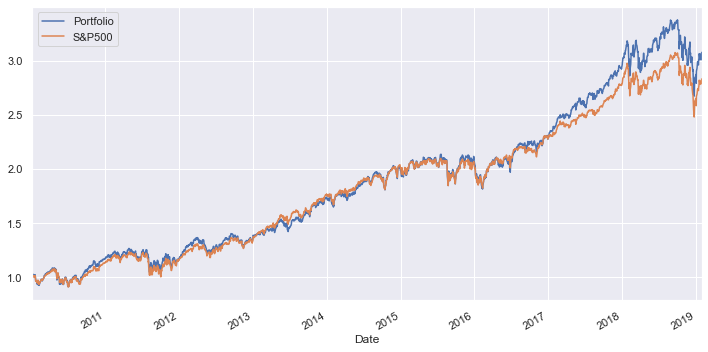

In [9]:
import tkinter as tk
import tkinter.font as tkFont
from tkinter import *
from tkinter import ttk
from tkcalendar import Calendar, DateEntry
from tkinter import filedialog
import threading
import datetime

window = tk.Tk()
window.title("Portfolio")
fontStyle = tkFont.Font(family="Lucida Grande", size=20)

start_date_button1 = tk.Button(window, text='Star Date', command=calender_start1, width=20, height=1, font=fontStyle)
start_date_button1.grid(row=1, column=1)

end_date_button1 = tk.Button(window, text='End Date', command=calender_end1, width=20, height=1, font=fontStyle)
end_date_button1.grid(row=1, column=2)

browse_button1 = tk.Button(window, text='Browse Tickers', command=browse1, width=20, height=1, font=fontStyle)
browse_button1.grid(row=1,column=3)

MG_Button = tk.Button(window, text='BackTest!', command=BackTest, width=20, height=1, font=fontStyle)
MG_Button.grid(row=1,column=4)

window.mainloop()